In [1]:
import os, sys

codepath = '/user_data/mmhender/image_stats_gabor/code/'
sys.path.insert(0,codepath)

import numpy as np

import matplotlib.pyplot as plt
from matplotlib import cm

import pandas as pd

from plotting import plot_utils
from model_fitting import initialize_fitting 
from utils import numpy_utils, default_paths, prf_utils
from analyze_features import analyze_feature_decoding


In [2]:
# Load everything

subject=998;
# subject=999; # 999 is our independent set of 10,000 COCO images
feature_type='gabor_solo'
which_prf_grid=5

path_to_load = default_paths.gabor_texture_feat_path
path_to_load = os.path.join(path_to_load, 'feature_decoding')
    
fn1 = os.path.join(path_to_load, 'S%d_%s_LDA_all_grid%d_matchprfs.npy'%(subject, feature_type, which_prf_grid))
print(fn1)
decoding = np.load(fn1,allow_pickle=True).item()
    
names = decoding['discrim_type_list']
acc = decoding['acc']
dprime = decoding['dprime']

n_axes = len(names)

prfs_use = acc[:,0]!=0
assert(np.all(prfs_use==prf_utils.get_prfs_use_decoding()))

/user_data/mmhender/features/gabor_texture/feature_decoding/S998_gabor_solo_LDA_all_grid5_matchprfs.npy


In [3]:
n = decoding['n_trials_eachlabel'][prfs_use]
np.unique(n)

array([1803])

In [5]:
assert(which_prf_grid==5)
models = prf_utils.get_prf_models(which_grid=which_prf_grid)
n_prfs = len(models)

x = models[:,0]*8.4; y = models[:,1]*8.4;
ecc = np.round(np.sqrt(models[:,0]**2+models[:,1]**2)*8.4, 4)
sizes = np.round(models[:,2]*8.4, 4)
angles = np.round(np.mod(np.arctan2(y,x)*180/np.pi, 360),1)

ecc_vals = np.unique(ecc)
size_vals = np.unique(sizes)
n_ecc = len(ecc_vals);
n_sizes = len(size_vals)
n_angles = len(np.unique(angles))

size_use = size_vals[5]
size_use

1.4763

<BarContainer object of 6 artists>

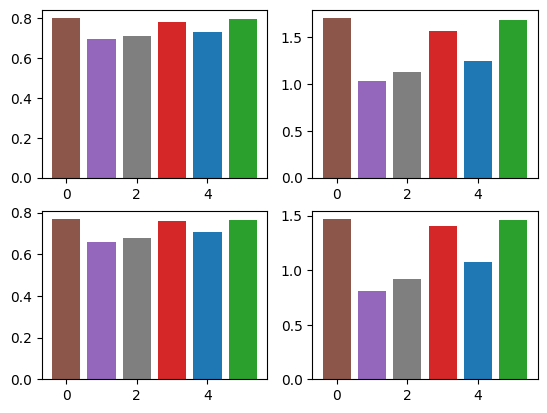

In [7]:
max_accs = np.max(acc[prfs_use,:], axis=0)
max_dprime = np.max(dprime[prfs_use,:], axis=0)
med_accs = np.median(acc[prfs_use,:], axis=0)
med_dprime = np.median(dprime[prfs_use,:], axis=0)
plt.figure()
plt.subplot(2,2,1)
plt.bar(np.arange(n_axes),max_accs, color=colors)
plt.subplot(2,2,2)
plt.bar(np.arange(n_axes),max_dprime, color=colors)
plt.subplot(2,2,3)
plt.bar(np.arange(n_axes),med_accs, color=colors)
plt.subplot(2,2,4)
plt.bar(np.arange(n_axes),med_dprime, color=colors)

In [36]:
np.unique(sizes[prfs_use])

array([1.4763, 2.2801, 3.5215, 5.4388, 8.4   ], dtype=float32)

In [9]:
names

['face-building',
 'face-none',
 'building-none',
 'animate-inanimate',
 'small-large',
 'indoor-outdoor']

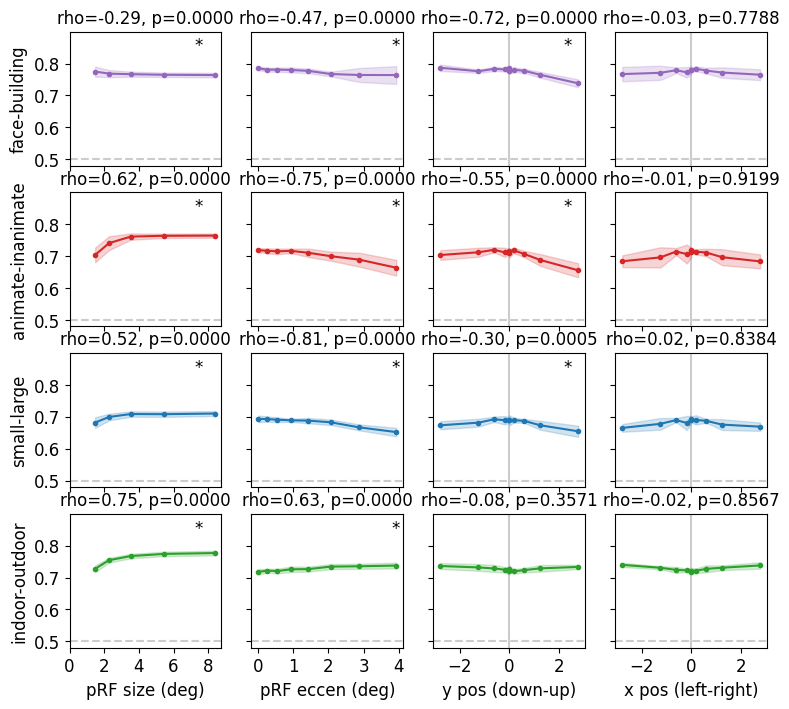

In [14]:
import scipy

plt.figure(figsize=(9,8));
plot_utils.set_all_font_sizes(12)
plt.rcParams['pdf.fonttype']=42

colors = cm.tab20(np.linspace(0,1,20))[[8,8,8,6,0,4],:]

axes_plot = [0,3,4,5]

n_bins=10
linear_bins=False

ylims = [0.48, 0.9];
yticks = [0.5, 0.6, 0.7, 0.8]
annot_yloc = 0.84

xticks = [[0,2,4,6,8], [0,1,2,3,4], [-2, 0, 2], [-2, 0, 2]]

par_names = ['pRF size (deg)', 'pRF eccen (deg)', 'y pos (down-up)', 'x pos (left-right)']

annot_xlocs = [7.2,3.8,2.2,2.2]

pi=0;

npx = len(axes_plot)

for ai in axes_plot:
    
    name = names[ai]
    
    for par_ind, par in enumerate([sizes, ecc, y, x]):

        pi+=1
        plt.subplot(npx,4,pi)

        if par_ind==0:
            prf_inds = prfs_use
        else:
            prf_inds = (prfs_use & (sizes==size_use))
            
        x_vals = par[prf_inds]
        vals = acc[prf_inds,ai]

        # plt.plot(x_vals, vals, '.', color=[0.8, 0.8, 0.8, 1])
        if par_ind>1:
            xbinned, ybinned, ystd = numpy_utils.bin_ydata_by_xdata(x_vals, vals, n_bins=n_bins, \
                                            linear_bins=linear_bins, return_std=True)  
        else:
            xbinned, ybinned, ystd = numpy_utils.bin_ydata_by_xdata(x_vals, vals, n_bins=n_bins, \
                                                linear_bins=linear_bins, return_std=True, \
                                                                use_unique=True)    
        plt.plot(xbinned, ybinned, '.-',color=colors[ai,:] ,zorder=10)
        plt.fill_between(xbinned, ybinned-ystd, ybinned+ystd,
                alpha=0.2, edgecolor=colors[ai,:], facecolor=colors[ai,:], zorder=10)

        if ai==5:
            plt.xlabel(par_names[par_ind])
            plt.xticks(xticks[par_ind])
        else:
            plt.xticks(xticks[par_ind], labels=[])
        if par_ind==0:
            plt.ylabel(name)
            plt.yticks(yticks)
        else:
            plt.yticks(yticks,[])
        plt.ylim(ylims)
        
        rho, p = scipy.stats.pearsonr(x_vals, vals)
        plt.title('rho=%.2f, p=%.4f'%(rho, p))
        if p<0.01:
            plt.annotate('*',(annot_xlocs[par_ind],annot_yloc))
            
        if par_ind>1:
            plt.axvline(0, color=[0.8, 0.8, 0.8])
            
        plt.axhline(0.5, linestyle='--',color=[0.8, 0.8, 0.8, 1])
        

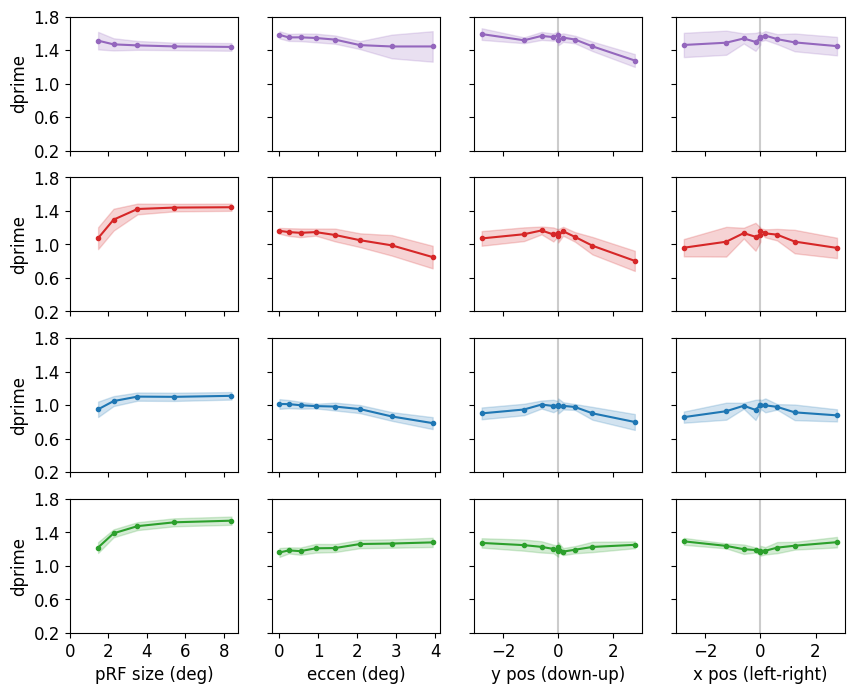

In [7]:
plt.figure(figsize=(10,8));
plot_utils.set_all_font_sizes(12)
plt.rcParams['pdf.fonttype']=42

axes_plot = [0,3,4,5]

colors = cm.tab20(np.linspace(0,1,20))[[8,14,14,6,0,4],:]


n_bins=10
linear_bins=False

ylims = [0.2, 1.8];
yticks = [0.2, 0.6, 1.0, 1.4, 1.8]

xticks = [[0,2,4,6,8], [0,1,2,3,4], [-2, 0, 2], [-2, 0, 2]]

pi=0;

npx = len(axes_plot)

for ai in axes_plot:
    
    name = names[ai]
    vals = dprime[prfs_use,ai]
    
    pi+=1
    plt.subplot(npx,4,pi)
    
    x_vals = sizes[prfs_use]

    xbinned, ybinned, ystd = numpy_utils.bin_ydata_by_xdata(x_vals, vals, n_bins=n_bins, \
                                            linear_bins=linear_bins, return_std=True, \
                                                            use_unique=True)    
    plt.plot(xbinned, ybinned, '.-',color=colors[ai,:] ,zorder=10)
    plt.fill_between(xbinned, ybinned-ystd, ybinned+ystd,
            alpha=0.2, edgecolor=colors[ai,:], facecolor=colors[ai,:], zorder=10)

    if ai==5:
        plt.xlabel('pRF size (deg)')
        plt.xticks(xticks[0])
    else:
        plt.xticks(xticks[0], labels=[])
    plt.ylabel('dprime')
    plt.ylim(ylims)
    plt.yticks(yticks)
    
    pi+=1
    plt.subplot(npx,4,pi)
    
    prf_inds = (prfs_use & (sizes==size_use))
    vals = dprime[prf_inds,ai]
    x_vals = ecc[prf_inds]

    xbinned, ybinned, ystd = numpy_utils.bin_ydata_by_xdata(x_vals, vals, n_bins=n_bins, \
                                            linear_bins=linear_bins, return_std=True, \
                                                            use_unique=True)    
    plt.plot(xbinned, ybinned, '.-',color=colors[ai,:] ,zorder=10)
    plt.fill_between(xbinned, ybinned-ystd, ybinned+ystd,
            alpha=0.2, edgecolor=colors[ai,:], facecolor=colors[ai,:], zorder=10)

    if ai==5:
        plt.xlabel('eccen (deg)')
        plt.xticks(xticks[1])
    else:
        plt.xticks(xticks[1], labels=[])
    plt.ylim(ylims)
    plt.yticks(yticks,labels=[])

    pi+=1
    plt.subplot(npx,4,pi)
    
    prf_inds = (prfs_use & (sizes==size_use))
    vals = dprime[prf_inds,ai]
    x_vals = y[prf_inds]


    xbinned, ybinned, ystd = numpy_utils.bin_ydata_by_xdata(x_vals, vals, n_bins=n_bins, \
                                            linear_bins=linear_bins, return_std=True)    
    plt.plot(xbinned, ybinned, '.-',color=colors[ai,:] ,zorder=10)
    plt.fill_between(xbinned, ybinned-ystd, ybinned+ystd,
            alpha=0.2, edgecolor=colors[ai,:], facecolor=colors[ai,:], zorder=10)

    if ai==5:
        plt.xlabel('y pos (down-up)')
        plt.xticks(xticks[3])
    else:
        plt.xticks(xticks[3], labels=[])
    plt.ylim(ylims)
    plt.yticks(yticks,labels=[])
    plt.axvline(0, color=[0.8, 0.8, 0.8])
    
    
    pi+=1
    plt.subplot(npx,4,pi)
    
    prf_inds = (prfs_use & (sizes==size_use))
    vals = dprime[prf_inds,ai]
    x_vals = x[prf_inds]


    xbinned, ybinned, ystd = numpy_utils.bin_ydata_by_xdata(x_vals, vals, n_bins=n_bins, \
                                            linear_bins=linear_bins, return_std=True)    
    plt.plot(xbinned, ybinned, '.-', color=colors[ai,:] ,zorder=10)
    plt.fill_between(xbinned, ybinned-ystd, ybinned+ystd,
            alpha=0.2, edgecolor=colors[ai,:], facecolor=colors[ai,:], zorder=10)

    if ai==5:
        plt.xlabel('x pos (left-right)')
        plt.xticks(xticks[2])
    else:
        plt.xticks(xticks[2], labels=[])
    # plt.ylabel('dprime')
    plt.ylim(ylims)
    plt.yticks(yticks,labels=[])
    plt.axvline(0, color=[0.8, 0.8, 0.8])
    
    
    

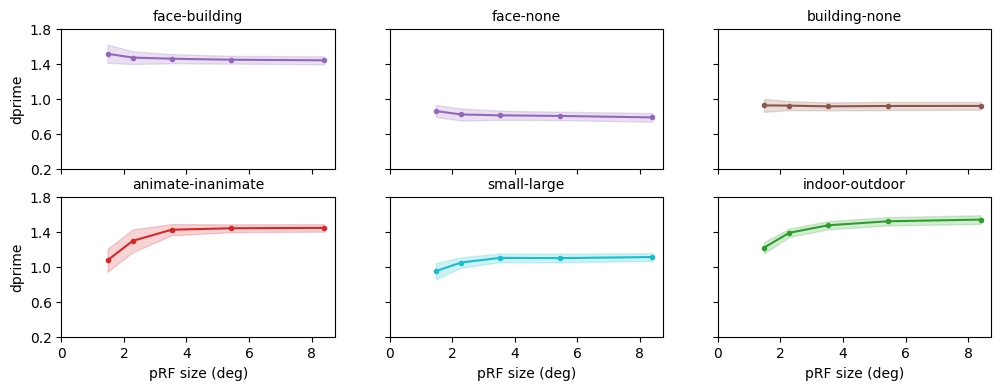

In [13]:
# plot dprime as a function of pRF params

plt.figure(figsize=(12,4));
plot_utils.set_all_font_sizes(10)
plt.rcParams['pdf.fonttype']=42

colors = cm.tab10(np.linspace(0,1,10))[[4,4,5, 3, 9,2],:]

n_bins=10
linear_bins=False

ylims = [0.2, 1.8];
yticks = [0.2, 0.6, 1.0, 1.4, 1.8]

xticks = [0,2,4,6,8]

pi=0;

for ai in range(n_axes):
    
    name = names[ai]
    vals = dprime[prfs_use,ai]
    
    pi+=1
    plt.subplot(2,3,pi)
    
    x_vals = sizes[prfs_use]

    xbinned, ybinned, ystd = numpy_utils.bin_ydata_by_xdata(x_vals, vals, n_bins=n_bins, \
                                            linear_bins=linear_bins, return_std=True, \
                                                            use_unique=True)    
    plt.plot(xbinned, ybinned, '.-',color=colors[ai,:] ,zorder=10)
    plt.fill_between(xbinned, ybinned-ystd, ybinned+ystd,
            alpha=0.2, edgecolor=colors[ai,:], facecolor=colors[ai,:], zorder=10)

    if ai>2:
        plt.xlabel('pRF size (deg)')
        plt.xticks(xticks)
    else:
        plt.xticks(xticks, labels=[])
        
    if np.mod(ai,3)==0:
        plt.ylabel('dprime')
        plt.yticks(yticks)
    else:
        plt.yticks(yticks,[])
    plt.ylim(ylims)
    
    plt.title(names[ai])
    
    

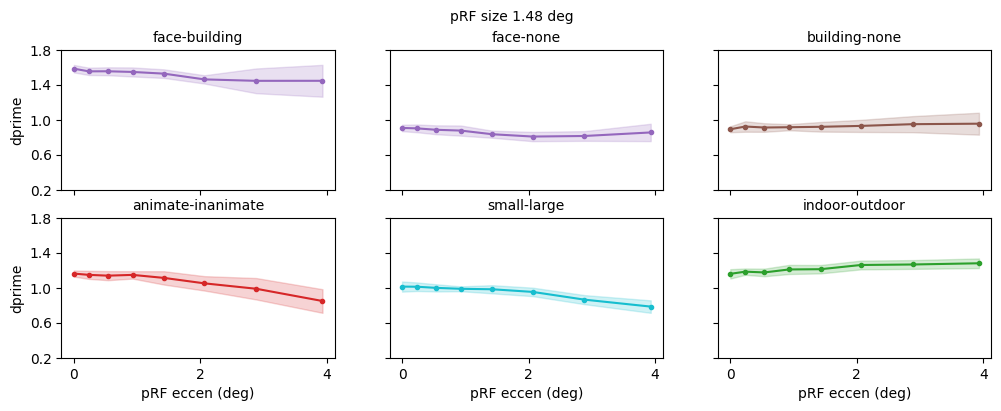

In [14]:
# plot dprime as a function of pRF params

for size_use in [size_vals[5]]:
# for size_use in np.unique(sizes[prfs_use]):

    plt.figure(figsize=(12,4));
    plot_utils.set_all_font_sizes(10)
    plt.rcParams['pdf.fonttype']=42

    colors = cm.tab10(np.linspace(0,1,10))[[4,4,5, 3, 9,2],:]

    n_bins=10
    linear_bins=False

    ylims = [0.2, 1.8];
    yticks = [0.2, 0.6, 1.0, 1.4, 1.8]

    xticks = [0,2,4]

    pi=0;

    for ai in range(n_axes):

        prf_inds = (prfs_use & (sizes==size_use))

        name = names[ai]
        vals = dprime[prf_inds,ai]

        pi+=1
        plt.subplot(2,3,pi)

        x_vals = ecc[prf_inds]

        xbinned, ybinned, ystd = numpy_utils.bin_ydata_by_xdata(x_vals, vals, n_bins=n_bins, \
                                                linear_bins=linear_bins, return_std=True, \
                                                                use_unique=True)    
        plt.plot(xbinned, ybinned, '.-',color=colors[ai,:] ,zorder=10)
        plt.fill_between(xbinned, ybinned-ystd, ybinned+ystd,
                alpha=0.2, edgecolor=colors[ai,:], facecolor=colors[ai,:], zorder=10)

        if ai>2:
            plt.xlabel('pRF eccen (deg)')
            plt.xticks(xticks)
        else:
            plt.xticks(xticks, labels=[])

        if np.mod(ai,3)==0:
            plt.ylabel('dprime')
            plt.yticks(yticks)
        else:
            plt.yticks(yticks,[])
        plt.ylim(ylims)

        plt.title(names[ai])

    plt.suptitle('pRF size %.2f deg'%size_use)

Text(0.5, 0.98, 'pRF size 1.48 deg')

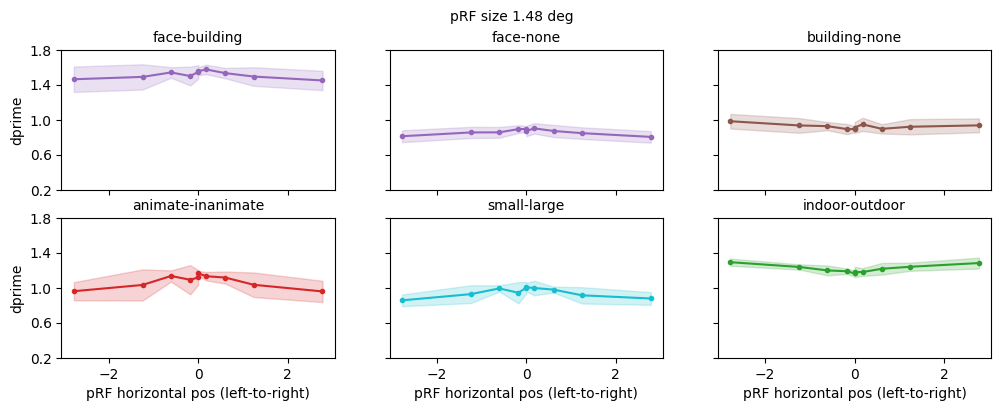

In [15]:
# plot dprime as a function of pRF params

plt.figure(figsize=(12,4));
plot_utils.set_all_font_sizes(10)
plt.rcParams['pdf.fonttype']=42

colors = cm.tab10(np.linspace(0,1,10))[[4,4, 5,3, 9,2],:]

n_bins=10
linear_bins=False

ylims = [0.2, 1.8];
yticks = [0.2, 0.6, 1.0, 1.4, 1.8]

xticks = [-2,0,2]

pi=0;

for ai in range(n_axes):
    
    prf_inds = (prfs_use & (sizes==size_use))
    
    name = names[ai]
    vals = dprime[prf_inds,ai]
    
    pi+=1
    plt.subplot(2,3,pi)
    
    x_vals = x[prf_inds]

    xbinned, ybinned, ystd = numpy_utils.bin_ydata_by_xdata(x_vals, vals, n_bins=n_bins, \
                                            linear_bins=linear_bins, return_std=True, \
                                                            use_unique=False)    
    plt.plot(xbinned, ybinned, '.-',color=colors[ai,:] ,zorder=10)
    plt.fill_between(xbinned, ybinned-ystd, ybinned+ystd,
            alpha=0.2, edgecolor=colors[ai,:], facecolor=colors[ai,:], zorder=10)

    if ai>2:
        plt.xlabel('pRF horizontal pos (left-to-right)')
        plt.xticks(xticks)
    else:
        plt.xticks(xticks, labels=[])
        
    if np.mod(ai,3)==0:
        plt.ylabel('dprime')
        plt.yticks(yticks)
    else:
        plt.yticks(yticks,[])
    plt.ylim(ylims)
    
    plt.title(names[ai])
    
plt.suptitle('pRF size %.2f deg'%size_use)

Text(0.5, 0.98, 'pRF size 1.48 deg')

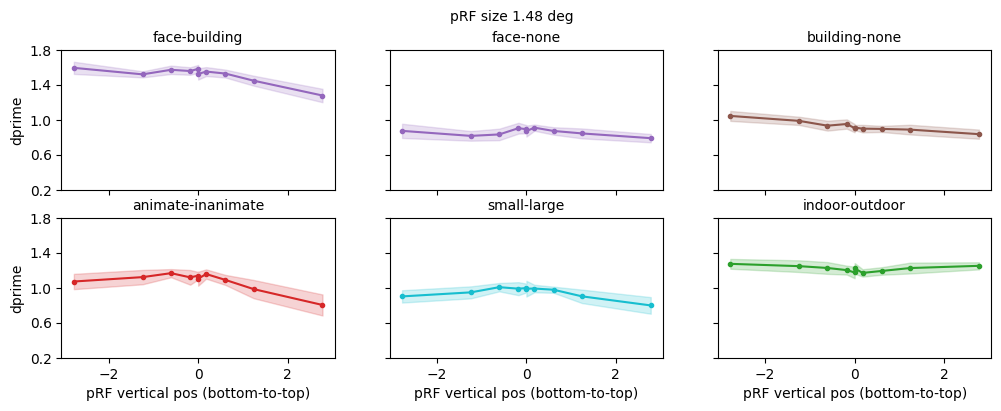

In [16]:
# plot dprime as a function of pRF params

plt.figure(figsize=(12,4));
plot_utils.set_all_font_sizes(10)
plt.rcParams['pdf.fonttype']=42

colors = cm.tab10(np.linspace(0,1,10))[[4, 4,5, 3, 9,2],:]

n_bins=10
linear_bins=False

ylims = [0.2, 1.8];
yticks = [0.2, 0.6, 1.0, 1.4, 1.8]

xticks = [-2,0,2]

pi=0;

for ai in range(n_axes):
    
    prf_inds = (prfs_use & (sizes==size_use))
    
    name = names[ai]
    vals = dprime[prf_inds,ai]
    
    pi+=1
    plt.subplot(2,3,pi)
    
    x_vals = y[prf_inds]

    xbinned, ybinned, ystd = numpy_utils.bin_ydata_by_xdata(x_vals, vals, n_bins=n_bins, \
                                            linear_bins=linear_bins, return_std=True, \
                                                            use_unique=False)    
    plt.plot(xbinned, ybinned, '.-',color=colors[ai,:] ,zorder=10)
    plt.fill_between(xbinned, ybinned-ystd, ybinned+ystd,
            alpha=0.2, edgecolor=colors[ai,:], facecolor=colors[ai,:], zorder=10)

    if ai>2:
        plt.xlabel('pRF vertical pos (bottom-to-top)')
        plt.xticks(xticks)
    else:
        plt.xticks(xticks, labels=[])
        
    if np.mod(ai,3)==0:
        plt.ylabel('dprime')
        plt.yticks(yticks)
    else:
        plt.yticks(yticks,[])
    plt.ylim(ylims)
    
    plt.title(names[ai])
    
plt.suptitle('pRF size %.2f deg'%size_use)